| **Metric**                            | **Definition**                                                                                                                   | **Units**             |
|--------------------------------------|----------------------------------------------------------------------------------------------------------------------------------|-----------------------|
| **Energy-to-solution** (Total Energy) | Total energy consumed by the job from start to finish. Essentially the area under the power-vs-time curve for the job.           | Joules (J) or kWh     |
| **Time-to-solution**                  | Total runtime of the job (wall-clock time from start to end).                                                                    | Seconds (s) or hours  |
| **Average power**                     | Mean power draw during the job. Computed as Energy-to-solution ÷ Time-to-solution. Reflects sustained load.                      | Watts (W)             |
| **Peak power**                        | Maximum instantaneous power draw observed during execution. Determined from power monitoring data.                               | Watts (W)             |
| **Energy-Delay Product (EDP)**        | Energy-to-solution × Time-to-solution. A combined efficiency metric balancing energy vs performance (lower is better).           | J·s (joule-seconds)   |
| **Perf/Watt (Throughput per energy)** | Application-specific work accomplished per unit energy (e.g. FLOPS per watt, or iterations per J).                               | Varies (e.g. FLOPS/W) |


In [1]:
from threading import Thread

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import h5py
import requests
import json

In [2]:
# Read and import the data file
files = glob.glob('examples/*.h5')
print(files)

file = files[0]
f = h5py.File(file, 'r')
nodes = list(f.keys())
for n in nodes:
    print("Node " + n + ": Tasks number: " + ', '.join([str(s) for s in f[n]['Tasks'].keys()]))
first_task = [str(s) for s in f[n]['Tasks'].keys()][0]


['examples/9646276_batch_c0107.h5', 'examples/9799476_batch_c0103.h5']
Node c0107: Tasks number: 0


In [3]:

df_tasks = pd.DataFrame(f[n]['Tasks'][ first_task][:])
df_tasks.drop_duplicates(inplace=True)




# Data
df_tasks['RSS_MB'] = df_tasks['RSS'] / 1024
df_tasks['CPUUtilization'] = df_tasks['CPUUtilization'] / 32
df_tasks

,ElapsedTime,EpochTime,CPUFrequency,CPUTime,CPUUtilization,GPUMemMB,GPUUtilization,RSS,VMSize,Pages,ReadMB,WriteMB,RSS_MB
0,0,1751978609,2300,0.000,0.000000,10596176,0.000000e+00,0,0,0,0.000000,0.000000,0.000000
1,30,1751978639,2300,0.140,0.014583,17592186044415,1.844674e+19,6620,0,0,1.745005,0.009249,6.464844
2,60,1751978669,2300,0.000,0.000000,17592186044415,1.844674e+19,5828,0,0,0.000000,0.000000,5.691406
3,60,1751978669,2300,0.001,0.000000,17592186044415,1.844674e+19,5224,0,0,0.000000,0.000000,5.101562


In [4]:
#Print the energy dataset

df_energy = pd.DataFrame(f[n]['Energy'][:])
df_energy.drop_duplicates(inplace=True)
df_energy

,ElapsedTime,EpochTime,NodePower
0,0,1751978609,264
2,1,1751978610,264
3,2,1751978611,264
4,3,1751978612,264
5,4,1751978613,264
...,...,...,...
60,59,1751978668,312
61,60,1751978669,312
62,61,1751978670,312
63,62,1751978671,312


In [5]:
df_energy_sorted = df_energy.sort_values('ElapsedTime')
df_tasks_sorted  = df_tasks.sort_values('ElapsedTime')

df = pd.merge_asof(
    df_energy_sorted,
    df_tasks_sorted,
    on='ElapsedTime',
    direction='nearest'
)

df = df.interpolate( kind='linear')
df

,ElapsedTime,EpochTime_x,NodePower,EpochTime_y,CPUFrequency,CPUTime,CPUUtilization,GPUMemMB,GPUUtilization,RSS,VMSize,Pages,ReadMB,WriteMB,RSS_MB
0,0,1751978609,264,1751978609,2300,0.000,0.0,10596176,0.000000e+00,0,0,0,0.0,0.0,0.000000
1,1,1751978610,264,1751978609,2300,0.000,0.0,10596176,0.000000e+00,0,0,0,0.0,0.0,0.000000
2,2,1751978611,264,1751978609,2300,0.000,0.0,10596176,0.000000e+00,0,0,0,0.0,0.0,0.000000
3,3,1751978612,264,1751978609,2300,0.000,0.0,10596176,0.000000e+00,0,0,0,0.0,0.0,0.000000
4,4,1751978613,264,1751978609,2300,0.000,0.0,10596176,0.000000e+00,0,0,0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1751978668,312,1751978669,2300,0.000,0.0,17592186044415,1.844674e+19,5828,0,0,0.0,0.0,5.691406
60,60,1751978669,312,1751978669,2300,0.001,0.0,17592186044415,1.844674e+19,5224,0,0,0.0,0.0,5.101562
61,61,1751978670,312,1751978669,2300,0.001,0.0,17592186044415,1.844674e+19,5224,0,0,0.0,0.0,5.101562
62,62,1751978671,312,1751978669,2300,0.001,0.0,17592186044415,1.844674e+19,5224,0,0,0.0,0.0,5.101562


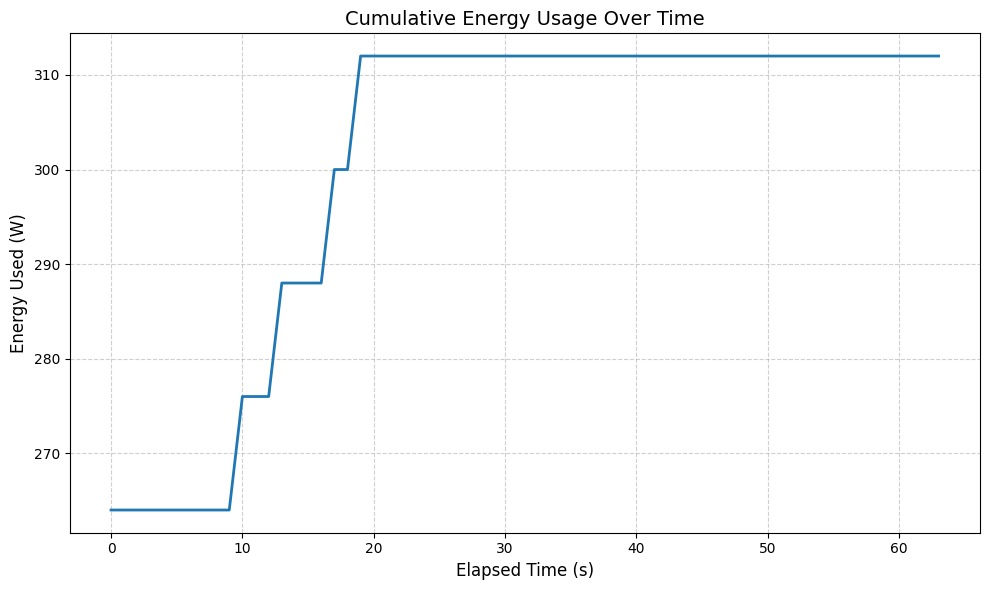

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(df['ElapsedTime'], df['NodePower'], linewidth=2)

plt.title('Cumulative Energy Usage Over Time', fontsize=14)
plt.xlabel('Elapsed Time (s)', fontsize=12)
plt.ylabel('Energy Used (W)', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


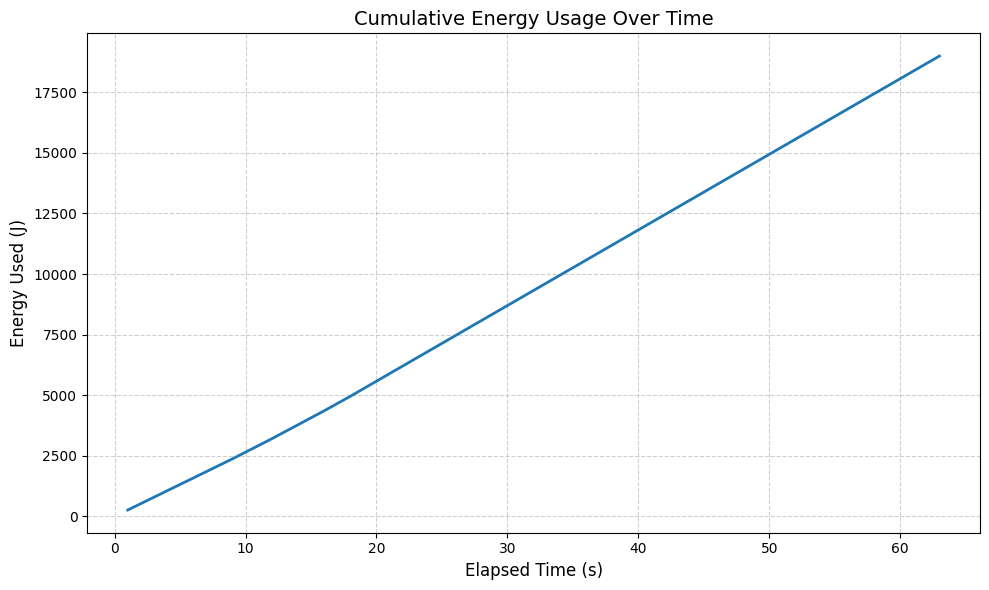

In [7]:
def comulative_energy_used(df):
     df['ElapsedTime'].diff().fillna(0)



df['Energy_used_J'] = (df['ElapsedTime'].diff()* df['NodePower']).cumsum()


plt.figure(figsize=(10, 6))
plt.plot(df['ElapsedTime'], df['Energy_used_J'], linewidth=2)

plt.title('Cumulative Energy Usage Over Time', fontsize=14)
plt.xlabel('Elapsed Time (s)', fontsize=12)
plt.ylabel('Energy Used (J)', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [9]:
import re

def describe_energy_use(joules, tuple=False):
    # Power ratings in watts (average values)
    appliances = [
        ("a hair dryer", 1800),
        ("a microwave oven", 1200),
        ("an electric kettle", 1500),
        ("a vacuum cleaner", 800),
        ("a refrigerator", 150),
        ("a light bulb", 60),
        ("a washing machine", 500),
        ("a gaming PC", 400),
        ("a laptop", 60),
        ("a dishwasher", 1000)
    ]

    # Best match: duration in 1-120 minutes range
    best = None
    best_delta = float('inf')
    best_time = 0

    for name, watts in appliances:
        seconds = joules / watts
        if seconds < 1:
            continue
        minutes = seconds / 60
        # Aim for durations in the 1-120 min (2 hour) range
        delta = abs(minutes - 10)
        if 1 <= minutes <= 120 and delta < best_delta:
            best = name
            best_delta = delta
            best_time = seconds

    if not best:
        if joules < 100:  # less than a single light bulb-second!
            return "it's like turning on a light bulb for a second."
        else:
            # Pick the closest, even if outside range
            name, watts = min(appliances, key=lambda x: abs((joules/x[1])/60 - 10))
            best = name
            best_time = joules / watts

    # Human readable time
    if best_time < 60:
        t = round(best_time, 1)
        time_str = f"{t} seconds"
        if tuple:
            time_str = f"s"
    elif best_time < 3600:
        t = round(best_time/60, 1)
        time_str = f"{t} minutes"
        if tuple:
            time_str = f"m"
    else:
        t = round(best_time/3600, 2)
        time_str = f"{t} hours"
        if tuple:
            time_str = f"h"

    if tuple:
        return best, t, time_str

    return f"That's about the same energy as using {best} for {time_str}."











print(f"The ETS Energy to Solution is a total of {df['Energy_used_J'].iloc[-1]}J")
print(f"Time to Solution was: {df['ElapsedTime'].iloc[-1]}s"  )
print(f"Average power draw was: {round(df['Energy_used_J'].iloc[-1]/df['ElapsedTime'].iloc[-1],2)}W")
print(f"While the Peak power draw was  {df['NodePower'].max()} W at time {df['ElapsedTime'].iloc[df.index[df['NodePower'] == df['NodePower'].max()][0]]} s")
print(f"Emergy to Delay product EDP: {df['ElapsedTime'].iloc[-1] * df['Energy_used_J'].iloc[-1]} J*s, Lower is Better")

print(describe_energy_use(df['Energy_used_J'].iloc[-1]))

if "/" in file:
    pattern = r'/(.*?)_'
if "//" in file:
    pattern = r'//(.*?)_'
job_id = re.search(pattern, file).group(1)



ets_energy = df['Energy_used_J'].iloc[-1]
tts = df['ElapsedTime'].iloc[-1]
avg_power = round(ets_energy / tts, 2)
peak_power = df['NodePower'].max()
peak_time = df['ElapsedTime'].iloc[df['NodePower'].idxmax()]
edp = ets_energy * tts

summary = [
    ['Energy-to-solution', f"{ets_energy:.2f}", 'J',
     'Total energy consumed by the job from start to finish.'],
    ['Time-to-solution', f"{tts:.2f}", 's',
     'Total runtime of the job (wall-clock time from start to end).'],
    ['Average power', f"{avg_power:.2f}", 'W',
     'Mean power draw during the job.'],
    ['Peak power', f"{peak_power:.2f} at {peak_time}s", 'W',
     'Maximum instantaneous power draw observed during execution.'],
    ['Energy-Delay Product (EDP)', f"{edp:.2f}", 'J·s',
     'Energy-to-solution × Time-to-solution. Lower is better.'],
    [f' It\' like having {describe_energy_use(ets_energy, tuple= True)[0]} on for',f'{describe_energy_use(ets_energy, tuple= True)[1]}' , f'{describe_energy_use(ets_energy, tuple= True)[2]}',
     'Total energy consumed by the job from start to finish.'],
]

df_summary = pd.DataFrame(summary, columns=['Metric', 'Value', 'Unit', 'Definition'])

styled = (
    df_summary.style
        .set_caption(f"Job {str(job_id)} Energy Metrics ")
        .hide(axis="index")
        .set_table_styles([
            {'selector': 'th', 'props': [('font-size', '13pt'), ('background-color', '#4b8bbe'), ('color', 'white')]},
            {'selector': 'caption', 'props': [('font-size', '14pt'), ('font-weight', 'bold')]}
        ])
)
styled

The ETS Energy to Solution is a total of 18996.0J
Time to Solution was: 63s
Average power draw was: 301.52W
While the Peak power draw was  312 W at time 19 s
Emergy to Delay product EDP: 1196748.0 J*s, Lower is Better
That's about the same energy as using a light bulb for 5.3 minutes.


Metric,Value,Unit,Definition
Energy-to-solution,18996.00,J,Total energy consumed by the job from start to finish.
Time-to-solution,63.00,s,Total runtime of the job (wall-clock time from start to end).
Average power,301.52,W,Mean power draw during the job.
Peak power,312.00 at 19s,W,Maximum instantaneous power draw observed during execution.
Energy-Delay Product (EDP),1196748.00,J·s,Energy-to-solution × Time-to-solution. Lower is better.
It' like having a light bulb on for,5.3,m,Total energy consumed by the job from start to finish.


In [10]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def find_closest(value, arr):
    """
    Binary-search helper to locate the array element closest to *value*.

    Parameters
    ----------
    value : numeric
        Target value for which the nearest neighbour is sought.
    arr : Sequence[numeric]
        **Sorted** ascending array (list, NumPy array, etc.) in which to search.

    Returns
    -------
    (best_val, best_idx) : tuple
        best_val  – element in *arr* with minimal |arr[i] − value|.
        best_idx  – index of best_val in *arr*.

    Notes
    -----
    • O(log n) time, O(1) space.
    • Tie-break: if two values are equally close, the smaller value wins
      (per original comparison `(diff == best_diff and arr[mid] < best_val)`).

    The algorithm keeps track of the currently best candidate (*best_val, best_idx*)
    while performing standard binary search.  It never mutates *arr*.
    """
    best_val, best_idx = arr[0], 0
    lo, hi = 0, len(arr) - 1

    while lo <= hi:
        mid = (lo + hi) // 2
        diff = abs(arr[mid] - value)
        best_diff = abs(best_val - value)

        if diff < best_diff or (diff == best_diff and arr[mid] < best_val):
            best_val, best_idx = arr[mid], mid

        if arr[mid] == value:
            return arr[mid], mid
        elif arr[mid] < value:
            lo = mid + 1
        else:
            hi = mid - 1

    return best_val, best_idx



def get_series_blocks(df, timestamps):
    """
    Build list of timestamp blocks (`series`) that cover the time-span
    in df['EpochTime_x'].
    Assumes:
      • df['EpochTime_x'] and `timestamps` are both in seconds
      • `timestamps` is sorted ascending
    Returns: list[int] – selected block start times
    """
    min_timestamp = min(df['EpochTime_x'])
    max_timestamp = max(df['EpochTime_x'])

    best_block_min, id_min = find_closest(min_timestamp, timestamps)


    series = []
    if best_block_min > min_timestamp and id_min > 0:
        series.append(timestamps[id_min-1])
        series.append(best_block_min)
    else:
        series.append(best_block_min)


    id_min_2 = timestamps.index(series[0])

    for i in range(id_min_2, len(timestamps)):
        if timestamps[i] < max_timestamp and series.count(timestamps[i]) == 0:
            series.append(timestamps[i])

    return series

def get_data(ts):
    ts = ts * 1000
    url = f"https://www.smard.de/app/chart_data/{filter_id}/{region}/{filter_id}_{region}_{resolution}_{ts}.json"
    data = requests.get(url).json()['series']
    return data

#INIT VALUES
filter_id = 4169
region = "DE-LU"
resolution = "quarterhour"


#Get Timestamps
url_index = f"https://www.smard.de/app/chart_data/{filter_id}/{region}/index_{resolution}.json"
timestamps = [x//1000 for x in requests.get(url_index).json()['timestamps']] #Remove ms
block_list = get_series_blocks(df, timestamps)


max_workers = int(os.getenv('SLURM_CPUS_ON_NODE', os.cpu_count()))
with ThreadPoolExecutor(max_workers=min(len(block_list), max_workers)) as executor:
    results = executor.map(get_data, block_list)
rows = np.concatenate(list(results), axis=0)

df_price = pd.DataFrame(rows, columns=['EpochTime_x','Price EUR/MWh'])
df_price ['EpochTime_x'] =(df_price['EpochTime_x']//1000).astype('uint64')
df

,ElapsedTime,EpochTime_x,NodePower,EpochTime_y,CPUFrequency,CPUTime,CPUUtilization,GPUMemMB,GPUUtilization,RSS,VMSize,Pages,ReadMB,WriteMB,RSS_MB,Energy_used_J
0,0,1751978609,264,1751978609,2300,0.000,0.0,10596176,0.000000e+00,0,0,0,0.0,0.0,0.000000,NaN
1,1,1751978610,264,1751978609,2300,0.000,0.0,10596176,0.000000e+00,0,0,0,0.0,0.0,0.000000,264.0
2,2,1751978611,264,1751978609,2300,0.000,0.0,10596176,0.000000e+00,0,0,0,0.0,0.0,0.000000,528.0
3,3,1751978612,264,1751978609,2300,0.000,0.0,10596176,0.000000e+00,0,0,0,0.0,0.0,0.000000,792.0
4,4,1751978613,264,1751978609,2300,0.000,0.0,10596176,0.000000e+00,0,0,0,0.0,0.0,0.000000,1056.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1751978668,312,1751978669,2300,0.000,0.0,17592186044415,1.844674e+19,5828,0,0,0.0,0.0,5.691406,17748.0
60,60,1751978669,312,1751978669,2300,0.001,0.0,17592186044415,1.844674e+19,5224,0,0,0.0,0.0,5.101562,18060.0
61,61,1751978670,312,1751978669,2300,0.001,0.0,17592186044415,1.844674e+19,5224,0,0,0.0,0.0,5.101562,18372.0
62,62,1751978671,312,1751978669,2300,0.001,0.0,17592186044415,1.844674e+19,5224,0,0,0.0,0.0,5.101562,18684.0


In [11]:


df = df.sort_values('EpochTime_x')
df_price  = df_price.sort_values('EpochTime_x')

df = pd.merge_asof(
    df,
    df_price,
    on='EpochTime_x',
    direction='nearest'
)
df['Cumulative_cost'] = (df['Energy_used_J']/ 3_600_000) * df['Price EUR/MWh']
df = df.interpolate( kind='linear')
df

,ElapsedTime,EpochTime_x,NodePower,EpochTime_y,CPUFrequency,CPUTime,CPUUtilization,GPUMemMB,GPUUtilization,RSS,VMSize,Pages,ReadMB,WriteMB,RSS_MB,Energy_used_J,Price EUR/MWh,Cumulative_cost
0,0,1751978609,264,1751978609,2300,0.000,0.0,10596176,0.000000e+00,0,0,0,0.0,0.0,0.000000,NaN,53.04,NaN
1,1,1751978610,264,1751978609,2300,0.000,0.0,10596176,0.000000e+00,0,0,0,0.0,0.0,0.000000,264.0,53.04,0.003890
2,2,1751978611,264,1751978609,2300,0.000,0.0,10596176,0.000000e+00,0,0,0,0.0,0.0,0.000000,528.0,53.04,0.007779
3,3,1751978612,264,1751978609,2300,0.000,0.0,10596176,0.000000e+00,0,0,0,0.0,0.0,0.000000,792.0,53.04,0.011669
4,4,1751978613,264,1751978609,2300,0.000,0.0,10596176,0.000000e+00,0,0,0,0.0,0.0,0.000000,1056.0,53.04,0.015558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1751978668,312,1751978669,2300,0.000,0.0,17592186044415,1.844674e+19,5828,0,0,0.0,0.0,5.691406,17748.0,53.04,0.261487
60,60,1751978669,312,1751978669,2300,0.001,0.0,17592186044415,1.844674e+19,5224,0,0,0.0,0.0,5.101562,18060.0,53.04,0.266084
61,61,1751978670,312,1751978669,2300,0.001,0.0,17592186044415,1.844674e+19,5224,0,0,0.0,0.0,5.101562,18372.0,53.04,0.270681
62,62,1751978671,312,1751978669,2300,0.001,0.0,17592186044415,1.844674e+19,5224,0,0,0.0,0.0,5.101562,18684.0,53.04,0.275278


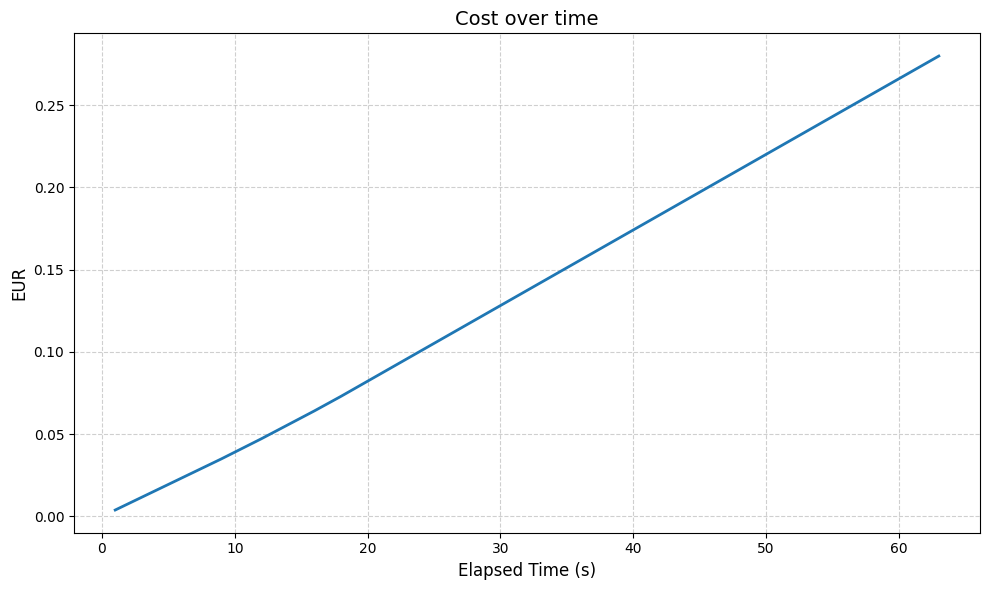

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df['ElapsedTime'], df['Cumulative_cost'], linewidth=2)

plt.title('Cost over time', fontsize=14)
plt.xlabel('Elapsed Time (s)', fontsize=12)
plt.ylabel('EUR', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()